In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision 
import torchvision.transforms as transforms
from PIL import Image
import os

from customDataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
# from sklearn.metrics import mean_squared_error


from neuralNet1 import NeuralNet
from VGG import VGGLoss
from scipy.ndimage import convolve

In [2]:
### Check if GPU is available

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Check for GPU availability and set device
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    device = torch.device("cuda")
    current_device_idx = torch.cuda.current_device()
else:
    device_count = 0
    device = torch.device("cpu")
    current_device_idx = None

# Print device information
print(f"Number of available GPUs: {device_count}")
print(f"Current device index: {current_device_idx}")
# print(f"Current device name: {torch.cuda.get_device_name(current_device_idx)}")

Using CPU
Number of available GPUs: 0
Current device index: None


In [3]:
# Dataset creation
# hyperparameters
batch_size = 8
train_X = "data/LR_train"
train_y = "data/HR_train"
val_X = "data/LR_val"
val_y = "data/HR_val"
test_X = "data/LR_test"
test_y = "data/HR_test"


# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define a transformation operation to normalize the images
transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize to [-1, 1]
])


# train_dataset = CustomDataset(train_X, train_y, transform=transforms.ToTensor())
# val_dataset = CustomDataset(val_X, val_y, transform=transforms.ToTensor())
# test_dataset = CustomDataset(test_X, test_y, transform=transforms.ToTensor())

# print("dataset size: ", len(train_dataset))

# #### Create the dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
#### Create the model
model = NeuralNet()

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# move them to device (GPU/CPU)
model.to(device)

# loss function
loss_fn1 = VGGLoss(device)
loss_fn2 = nn.MSELoss()

epochs = 100

In [5]:
### SAVE MODEL, LOAD MODEL, WORKS ANYWHERE ###

model_name = "model.pt"

# Save the model
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss
#             }, 'models/checkpoint.pth')

# Load the model
new_model = NeuralNet()
checkpoint = torch.load('checkpoint.pth',map_location=torch.device('cpu'))
new_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model = new_model

print(loss)

tensor(0.0026, requires_grad=True)


In [6]:
#### Training loop
for epoch in range(epochs):
    print(f"------------------\n Epoch: {epoch}")
    model.train()
    epoch_loss = 0
    batch_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        if i % 100 == 0:
            print(" Batch:", i, " Loss:", batch_loss/100)
            batch_loss = 0
        
        # retrieve data and move tensors to device
        inputs = X.to(device)
        labels = y.to(device)
        
        # calculate loss
        outputs = model(inputs)
        # loss = loss_fn1(outputs, labels)
        loss = loss_fn2(outputs, labels)
        epoch_loss += loss.item()
        batch_loss += loss.item()
        
        # zero gradient and backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # change learning rate
        if epoch/epochs > 0.5:
            optimizer = optim.Adam(model.parameters(), lr=1e-4)
            
        
    # Print epoch information 
    print(f"Epoch {epoch+1}/{epochs}: Loss: {epoch_loss:.4f}")
    

------------------
 Epoch: 0


NameError: name 'train_dataloader' is not defined

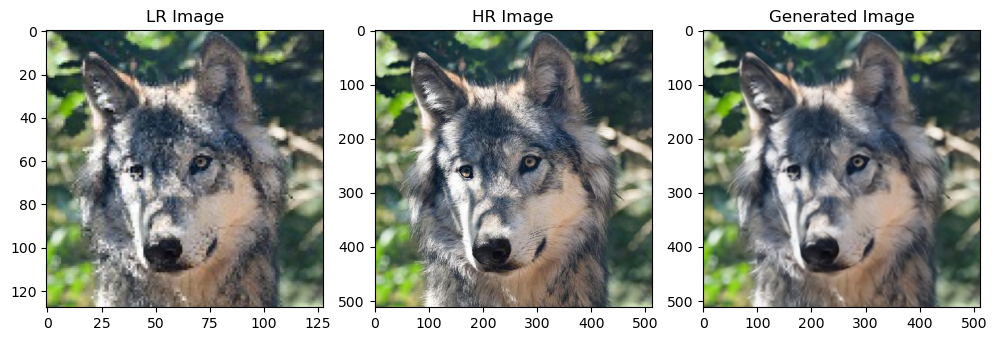

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


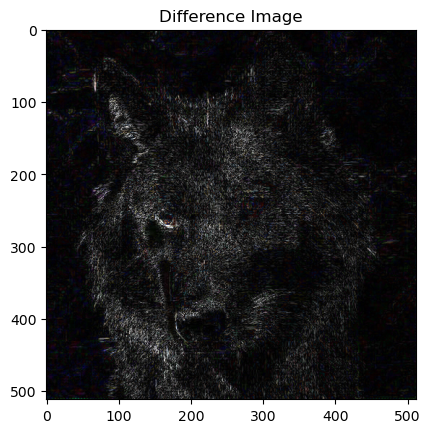

MSE: 216.5241928100586


In [122]:
##INFERENCE##
# lr_image = "LR_test/downscaled_ci_pixabay_dog_001489.jpg"
# hr_image = "HR_test/pixabay_dog_001489.jpg"
lr_image = "LR_test/downscaled_ci_pixabay_wild_000639.jpg"
hr_image = "HR_test/pixabay_wild_000639.jpg"
# lr_image = "downscaled_ci_waves.jpg"
# hr_image = "waves.jpg"
# Set the model to evaluation mode
model.eval()

image = Image.open(lr_image)
input_image = transform(image)

# Perform the inference
with torch.no_grad():
    input_image = input_image.to(device)  # Move the input image to the device
    input_image = input_image.unsqueeze(0)  # Add a batch dimension
    output = model(input_image)

# Convert to numpy array
numpy_image = output.squeeze(0).cpu().detach().numpy()

# Change the order of the dimensions from (C, H, W) to (H, W, C)
numpy_image = np.transpose(numpy_image, (1, 2, 0))
output_im = np.array(numpy_image*255,dtype=int)

### Display the images###

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Display images in subplots
axes[0].imshow(plt.imread(lr_image))
axes[0].set_title('LR Image')

target = plt.imread(hr_image)
axes[1].imshow(target)
axes[1].set_title('HR Image')

axes[2].imshow(output_im)
axes[2].set_title('Generated Image')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

difference = abs(output_im - target)
plt.imshow(difference*2)
plt.title("Difference Image")
plt.show()

# find mse between original and reconstructed image
mse = np.mean(difference**2)
print("MSE:", mse)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


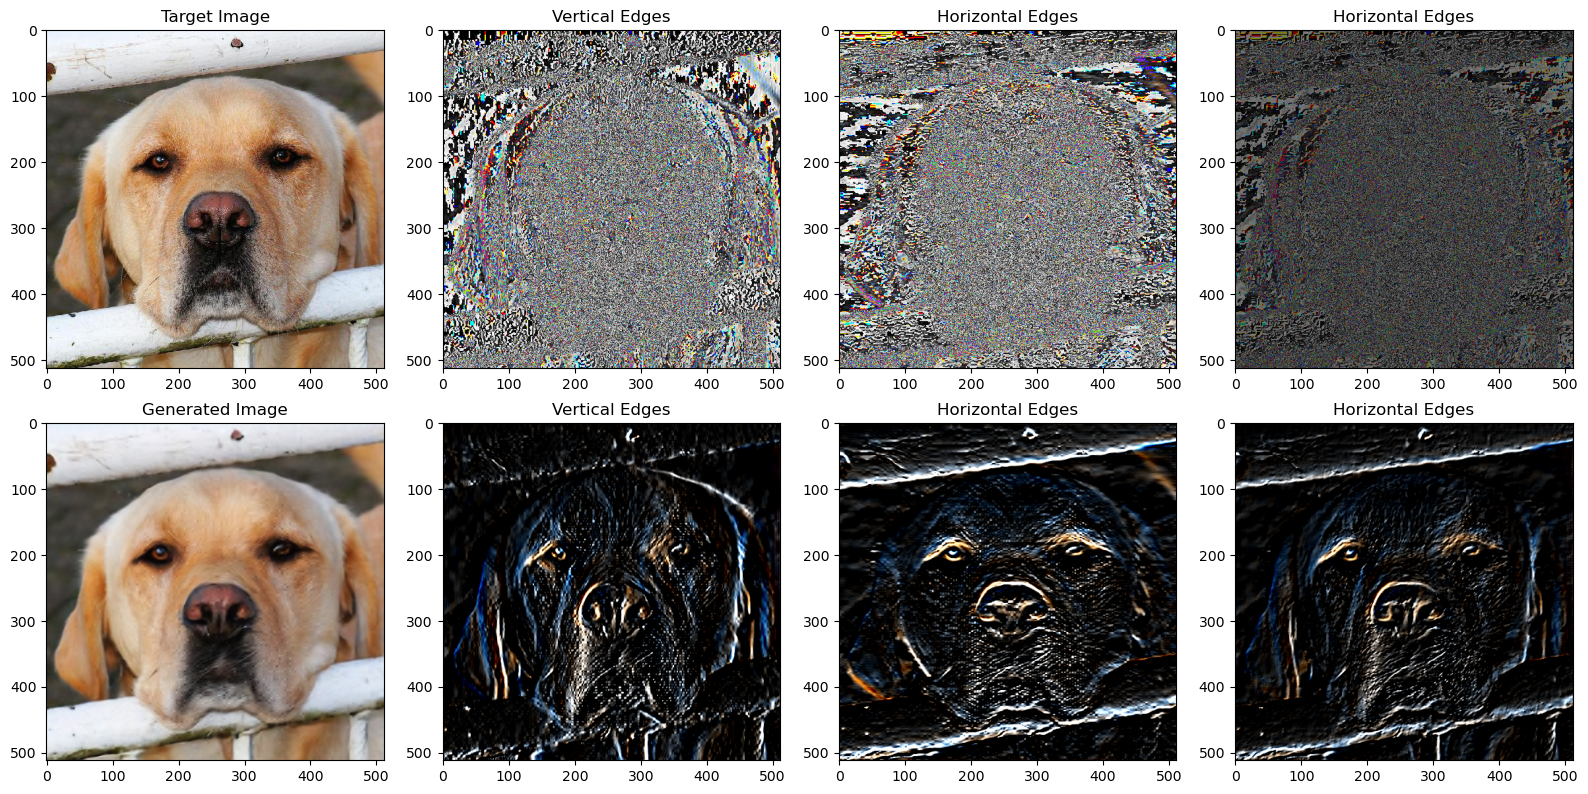

In [82]:
##some conv attempts##
#image = transform.ToPILImage()(image)
'''
v_kernel is conv kernel to detect vertical edges, similar for h_kernel
sobel kernel is a specific kernel that also detects edges
'''
# v_kernel = np.array([[[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]]])
v_kernel = np.array([[[-1,-1,-1],[0,0,0],[1,1,1]],
                     [[-2,-2,-2],[0,0,0],[2,2,2]],
                     [[-1,-1,-1],[0,0,0],[1,1,1]]])
h_kernel = np.transpose(v_kernel,(1,0,2))


target = plt.imread(hr_image)
target_v_edges = convolve(target, v_kernel)
target_h_edges = convolve(target,h_kernel)
target_avg = (target_v_edges + target_h_edges)//2

generated_v_edges = convolve(output_im, v_kernel)
generated_h_edges = convolve(output_im,h_kernel)
generated_avg = (generated_h_edges+generated_v_edges)//2
# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Display images in subplots
axes[0][0].imshow(target)
axes[0][0].set_title('Target Image')
axes[1][0].imshow(output_im)
axes[1][0].set_title('Generated Image')

axes[0][1].imshow(target_v_edges)
axes[0][1].set_title('Vertical Edges')
axes[1][1].imshow(generated_v_edges)
axes[1][1].set_title('Vertical Edges')

axes[0][2].imshow(target_h_edges)
axes[0][2].set_title('Horizontal Edges')
axes[1][2].imshow(generated_h_edges)
axes[1][2].set_title('Horizontal Edges')

axes[0][3].imshow(target_avg)
axes[0][3].set_title('Horizontal Edges')
axes[1][3].imshow(generated_avg)
axes[1][3].set_title('Horizontal Edges')

# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()




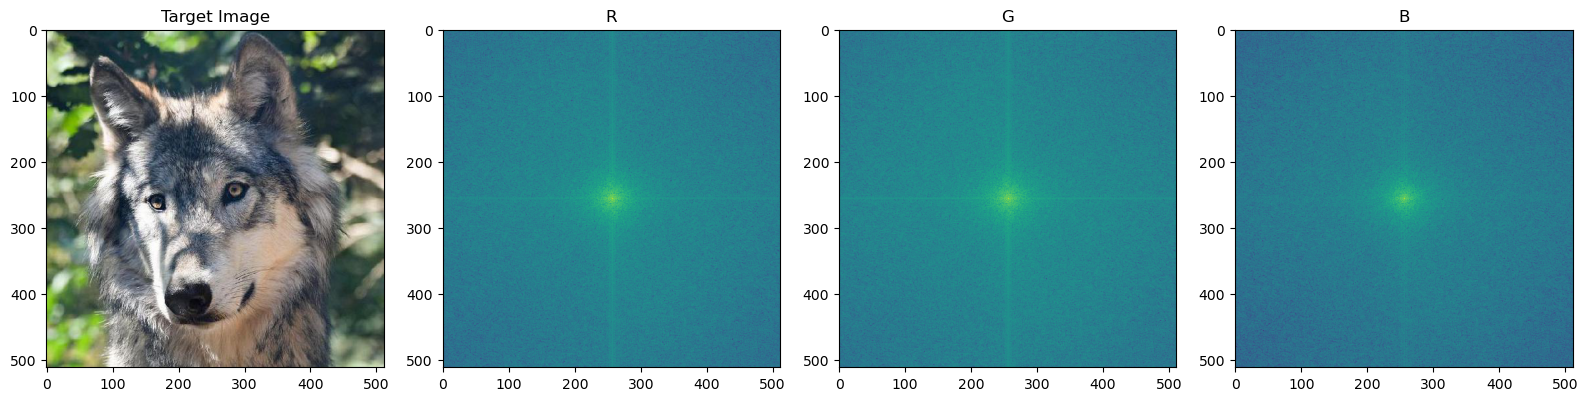

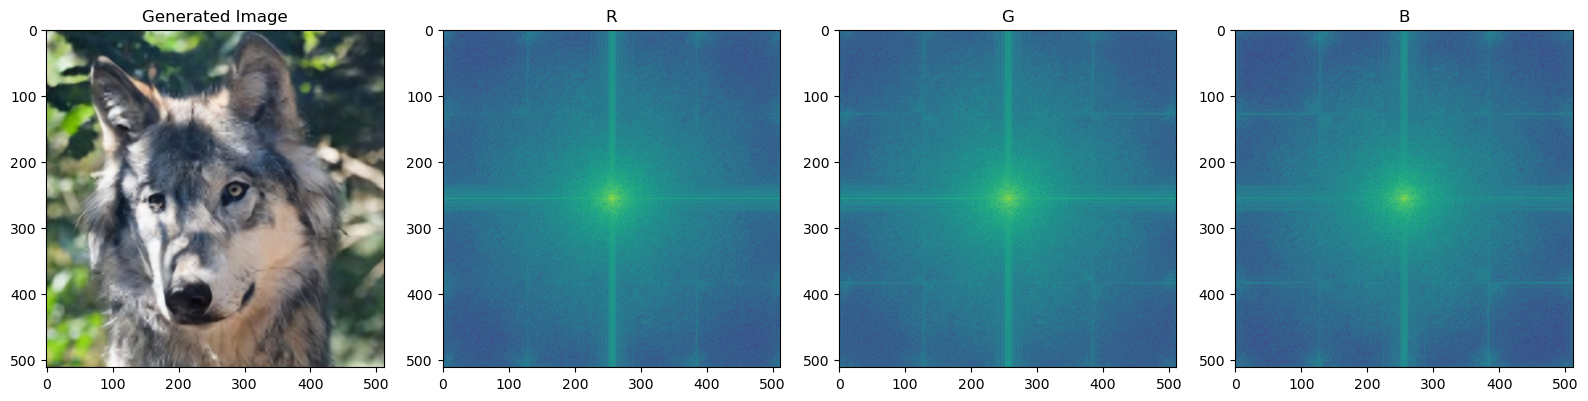

done


In [412]:
# Fourier Analysis
def fourier_map(img,title,display=True):
    
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]

    # Perform Fourier Transform for each color channel
    r_fft = np.fft.fftshift(np.fft.fft2(r))
    g_fft = np.fft.fftshift(np.fft.fft2(g))
    b_fft = np.fft.fftshift(np.fft.fft2(b))

    # Compute magnitude spectra for each color channel
    r_magnitude_spectrum = 32 * np.log(np.abs(r_fft))
    g_magnitude_spectrum = 32 * np.log(np.abs(g_fft))
    b_magnitude_spectrum = 32 * np.log(np.abs(b_fft))

    # Display the original image and magnitude spectra for each color channel
    # Create a figure with subplots

    if display:
        fig, axes = plt.subplots(1, 4, figsize=(16, 8))
        # Display images in subplots
        axes[0].imshow(img)
        axes[0].set_title(title)
        axes[1].imshow(r_magnitude_spectrum)
        axes[1].set_title('R')
        axes[2].imshow(g_magnitude_spectrum)
        axes[2].set_title('G')
        axes[3].imshow(b_magnitude_spectrum)
        axes[3].set_title('B')
        plt.tight_layout()
        plt.show()
    return r_magnitude_spectrum,g_magnitude_spectrum,b_magnitude_spectrum

fourier_map(target,"Target Image")
fourier_map(output_im,"Generated Image")
print("done")

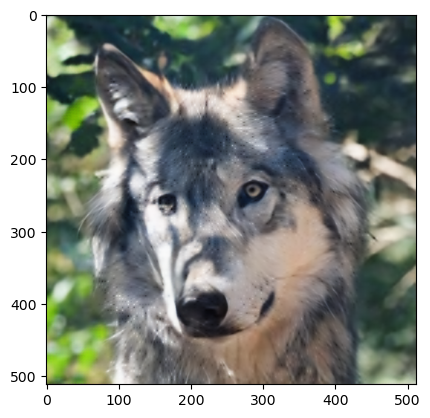

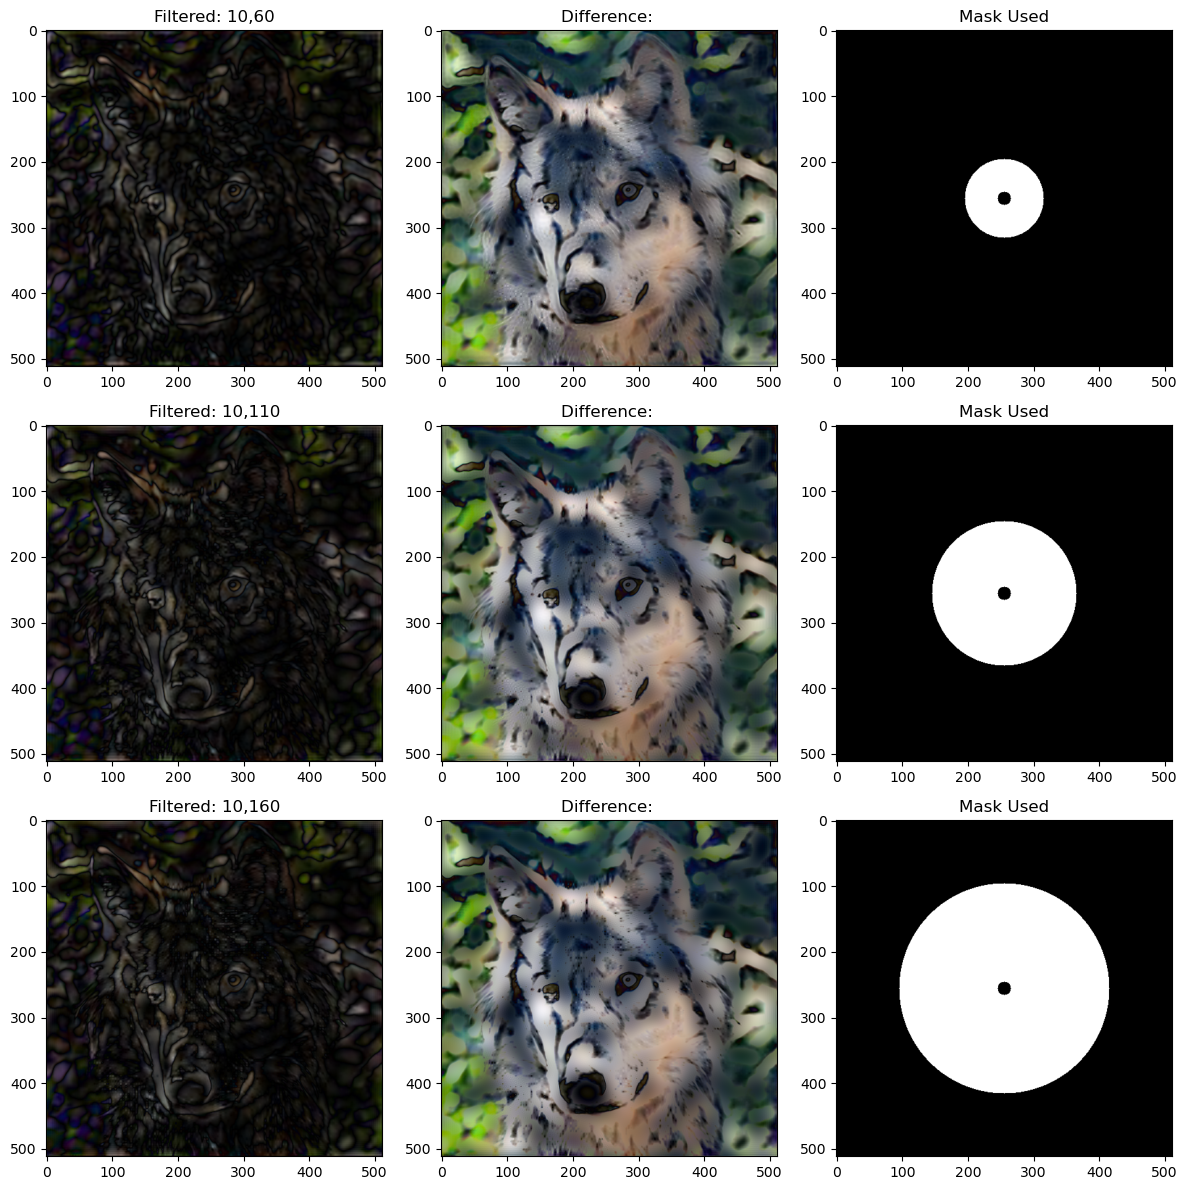

In [448]:
#Band Pass Fourier Filters 
# Apply high-pass filtering on each color channel
def high_pass_channel(channel, mask):
    #transform to frequency domain with FFT
    f = np.fft.fft2(channel)
    f_shift = np.fft.fftshift(f)
    
    f_shift_filtered = f_shift * mask#mask specific frequencies
    
    #invert back to get new image
    f_inverse_shift = np.fft.ifftshift(f_shift_filtered)
    channel_filtered = np.fft.ifft2(f_inverse_shift)
    channel_filtered = np.abs(channel_filtered).astype(int)
    return channel_filtered

def high_pass_filter(img,r1,r2):

    # Split the image into color channels
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    rows, cols, depth = img.shape
    center_row, center_col = rows // 2, cols // 2
    # # Create a circular mask
    mask = np.zeros((rows, cols), np.uint8)#get rid of everything
    mask = cv2.circle(mask, (center_col, center_row), r2, 1, -1)#actually keep disk of r2
    # plt.imshow(mask,cmap='gray')
    # plt.show()
    # print(mask)
    if r1>0:
        mask = cv2.circle(mask, (center_col, center_row), r1, 0, -1)    #actually get rid of disk r1
    
    r_filtered = high_pass_channel(r, mask)
    g_filtered = high_pass_channel(g, mask)
    b_filtered = high_pass_channel(b, mask)

    # Merge the filtered color channels
    filtered_image = cv2.merge((r_filtered, g_filtered, b_filtered))
    return filtered_image,mask

# rows = 6
# cols = 6
# scale = 363//rows//cols
# fig, axes = plt.subplots(rows,cols, figsize=(8*rows, 8*cols))
# outer_radius = 363
# for i in range(rows):
#     for j in range(cols):
#         inner_radius = scale*(cols*i+j+1)
#         filtered = high_pass_filter(output_im,inner_radius,outer_radius)
#         axes[i][j].imshow(filtered)
#         axes[i][j].set_title(str(inner_radius)+","+str(outer_radius))
# plt.tight_layout()
# plt.show()
img = output_im
plt.imshow(img)
plt.show()
fig, axes = plt.subplots(3,3,figsize=(12,12))
for i in range(3):
    # inner = (i*(i+19)**2)//400
    inner=10
    outer = inner+50*(i+1)
    filtered,mask = high_pass_filter(img,inner,outer)
    change = abs(filtered - img)
    axes[i][0].imshow(filtered)
    axes[i][0].set_title("Filtered: " + str(inner)+","+str(outer))
    axes[i][1].imshow(change)
    axes[i][1].set_title("Difference: ")
    axes[i][2].imshow(mask,cmap='gray')
    axes[i][2].set_title("Mask Used")
plt.tight_layout()
plt.show()

# filtered,mask = high_pass_filter(img,30,100)
# plt.imshow(filtered)
# plt.show()